## Purposes
- To apply Upper-Confidence-Bound Action Selection (UCB)
- To train model from easy to difficult scenario 

## Import

In [1]:
import utils
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from src.env import Coinworld
from itertools import zip_longest
from collections import deque, namedtuple

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from statsmodels.iolib.table import SimpleTable

## Hyperparameters

In [3]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.996             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

## 3 - Coinworld Evironment
The goal of Coinworld evironment is to earn profit and maintain it from foreign exchange. Agent is only allow to trade and hold 1 currency at a time.

In [4]:
input = pd.read_pickle(r'C:\Users\Dell\OneDrive\Documents\projects\trading_bot_v0\Processed_Dataset_from_1Jan22_17Feb24.pkl') # Importing dataset from pickle
series = np.array(input[['close', 'RSI','MACD_0', 'MACD_1', 'MACD_2']][-1200:-980]) # Choosing last 1000 data points in close column
env = Coinworld(series)
env.reset()

array([0.00000000e+00, 0.00000000e+00, 2.00000000e+01, 0.00000000e+00,
       5.11630898e+04, 7.77523478e+01, 4.81335350e+01, 3.51167350e+01,
       1.30168000e+01])

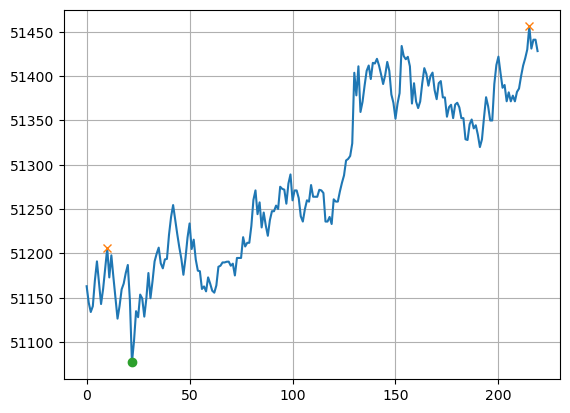

No more steps can be taken
1.1891415991467085 20.10810378174061


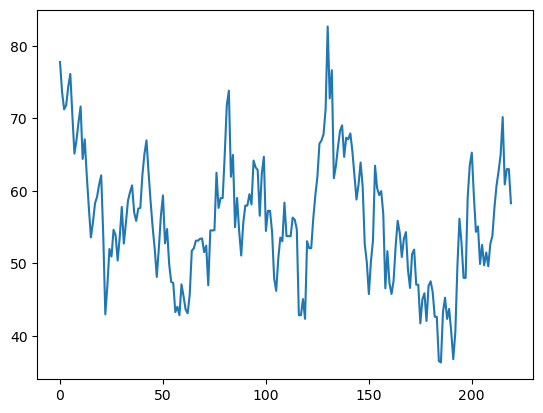

In [5]:
##  Optimistic Initial Values - Local Minima and Maxima
import numpy as np
from scipy.signal import find_peaks

# Example time series data
start = -3000
end = start+3000 if start<-3000 else None
data = np.array(series[start:end,0])

# Set prominence and distance
prominence = 10
distance = 200
width = None
height= 30
rel_height=0.5

# Find local maxima
peaks, _ = find_peaks(data, prominence=prominence, distance=distance)
# print("Local maxima indices:", peaks)
# print("Local maxima values:", data[peaks])

# Find local minima by inverting the signal
min_peaks, _ = find_peaks(-data, prominence=prominence, distance=distance)
# print("Local minima indices:", min_peaks)
# print("Local minima values:", data[min_peaks])

plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.plot(min_peaks, data[min_peaks], "o")
# plt.axis([27000,30000, None,None])
plt.grid(True)
plt.show()

plt.plot(series[:,1])


# Buy at the local minima and sell at the local maxima
action_ini = np.array([0] * len(data))
# print([i for i in action_ini])
action_ini[list(peaks)] = 2
action_ini[list(min_peaks)] = 1

total_points = 0
env.reset()
for i in range (len(data)):
    next_state, reward, done = env.step(action_ini[i])
    total_points += reward

print(total_points, env.state[0]*env.state[1]+env.state[2])


## 4 - Deep Q-learning

In [6]:
state_size = env.get_state_space_size()
num_actions = env.get_action_space_size()

# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    # Lambda(lambda q_values: tf.expand_dims(tf.reduce_max(q_values, axis=1), axis=1))
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    # Lambda(lambda q_values: tf.expand_dims(tf.reduce_max(q_values, axis=1), axis=1))
    ])

optimizer = Adam(learning_rate=ALPHA)


In [8]:
isinstance(q_network, Sequential)

True

### 4.1 - Experience/Q-table

In [ ]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

### 4.2 - Loss function

In [ ]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values) 
    ### END CODE HERE ### 
    
    return loss

In [ ]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [ ]:
plt.plot(series[:,0])

## Training


$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

$$
A_t = argmax_{a}[Q_t(a) + c\sqrt{\hbox{$\frac{\ln t}{N_t(a)}$}}]

$$

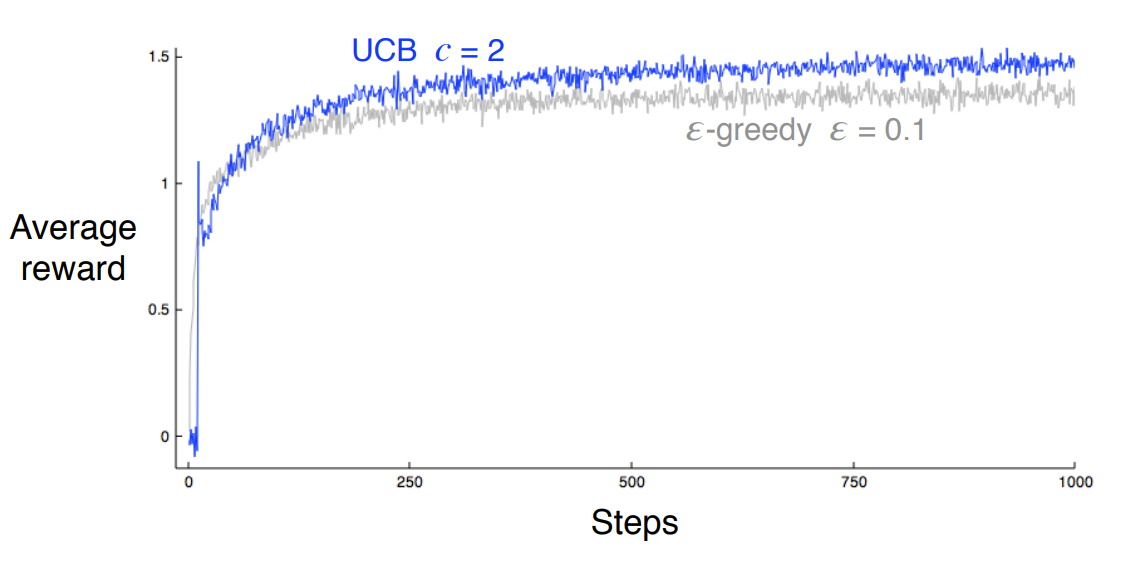

In [35]:
start = time.time()

num_episodes = 1
max_num_timesteps = len(env.series)

total_point_history = []

num_p_av = 1    # number of total points to use for averaging
# epsilon = 1     # initial ε value for ε-greedy policy
c = 2             # Control exploration (defaut: 1, 2)
n_a = np.zeros((max_num_timesteps, num_actions)) + 1e-10

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights()) 

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Episode 1 | Total point average of the last 1 episodes: -58.52 n_a: [1.e+00 1.e-10 1.e-10]


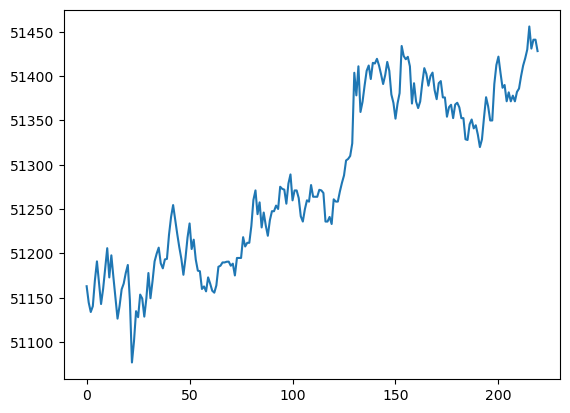


Total Runtime: 3.70 s (0.06 min)


In [36]:
for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        try:
            q_values = q_network(state_qn)
        except Exception as e:
            print(e, state_qn)

        action = utils.get_ucb_action(q_values, c, t, n_a[t])
        n_a[t, action] += 1
        print(action)
        # Take action A and receive reward R and the next state S'
        # next_state, reward, done, _ = env.step(action)
        next_state, reward, done = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    # epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f} n_a: {n_a[t,]}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f} ") 
        utils.plot_trading_strategy(env, q_network)
    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 2000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('trading_model_1.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

In [40]:
q_network(np.expand_dims(env.state, axis=0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1212.7524, 1194.93  , 1208.6648]], dtype=float32)>

In [39]:
np.sum(n_a, axis=0)

array([1.43e+02, 2.20e-08, 7.60e+01])

In [ ]:
plot_1 = [0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
points = 0
for i in range(20):
    state, reward, done = env.step(plot_1[0])
    # points += reward
    print(reward)
    # if done:
    #     break